# Multivariate LSTM

Lets now make a useful example using mutivariate timeseries with several features



## 01 - Set the drive path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 02 - Install the required packages versions

In [ ]:
!pip install -U seaborn==0.9.0
!pip install -U pandas==0.25
!pip install -U tensorflow==1.5


Requirement already up-to-date: seaborn==0.9.0 in /usr/local/lib/python3.6/dist-packages (0.9.0)
Requirement already up-to-date: pandas==0.25 in /usr/local/lib/python3.6/dist-packages (0.25.0)
Requirement already up-to-date: tensorflow==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0)


## 03 - Set the folfers path

In [ ]:
BASE_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/'

PLOTS_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/plots/'
DUMPS_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/dumps/'
DATA_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/data/'
CHECK_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/checkpoints/'

IMAGES_PATH = '/content/drive/MyDrive/PRODEI_PSST/hso_psst_final_delivery/images/'


## 04 - Import the packages

In [ ]:
# Lets set our packages imports
import tensorflow as tf


import numpy as np
import pandas as pd 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set() # Set the seaborn plots enviroment


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

## 05 - Read the data and pre-process Dataset pre-processing ans analysis


In [ ]:

# Read the dataset into a pandas df
df = pd.read_csv(DATA_PATH + 'sentiment-bitcoin.csv')

# Quick overview
df.head()


,Unnamed: 0,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
0,2018-07-11 20:00:00,0.102657,0.216148,4354.0,6342.97,6354.19,6291.00,986.73,6231532.37,6350.00
1,2018-07-11 21:00:00,0.098004,0.218612,4432.0,6352.99,6370.00,6345.76,126.46,804221.55,6356.48
2,2018-07-11 22:00:00,0.096688,0.231342,3980.0,6350.85,6378.47,6345.00,259.10,1646353.87,6361.93
3,2018-07-11 23:00:00,0.103997,0.217739,3830.0,6362.36,6381.25,6356.74,81.54,519278.69,6368.78
4,2018-07-12 00:00:00,0.094383,0.195256,3998.0,6369.49,6381.25,6361.83,124.55,793560.22,6380.00


Some messy columns found, rename it 

In [ ]:
# Do some column renaming 
df = df.rename(columns = {'Unnamed: 0': 'timestamp'})
df.head()


,timestamp,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
0,2018-07-11 20:00:00,0.102657,0.216148,4354.0,6342.97,6354.19,6291.00,986.73,6231532.37,6350.00
1,2018-07-11 21:00:00,0.098004,0.218612,4432.0,6352.99,6370.00,6345.76,126.46,804221.55,6356.48
2,2018-07-11 22:00:00,0.096688,0.231342,3980.0,6350.85,6378.47,6345.00,259.10,1646353.87,6361.93
3,2018-07-11 23:00:00,0.103997,0.217739,3830.0,6362.36,6381.25,6356.74,81.54,519278.69,6368.78
4,2018-07-12 00:00:00,0.094383,0.195256,3998.0,6369.49,6381.25,6361.83,124.55,793560.22,6380.00


## 06 - Time series analisys 


Detect Sudden Changes on the Time Series


In [ ]:
# Function to indnetify the peaks above a certain threshold
def detect(signal, treshold = 2.0):
    detected = []
    for i in range(len(signal)):
        if np.abs(signal[i]) > treshold:
            detected.append(i)
    return detected


In [ ]:
# We are only intereted in the target variable
signal = np.copy(df['Close_Price'].values)

# Scale the variable to zero mean and unit variance
std_signal = (signal - np.mean(signal)) / np.std(signal)

# Convert again to a series
s = pd.Series(std_signal)

# Show the important percentiles
s.describe(percentiles = [0.25, 0.5, 0.75, 0.95])


count    2.940000e+02
mean     2.409259e-15
std      1.001705e+00
min     -1.365972e+00
25%     -1.127892e+00
50%      6.410081e-01
75%      8.936113e-01
95%      1.375160e+00
max      1.470319e+00
dtype: float64

Plot those changes

In [ ]:
# Lets indentify them
outliers = detect(std_signal, 1.3)


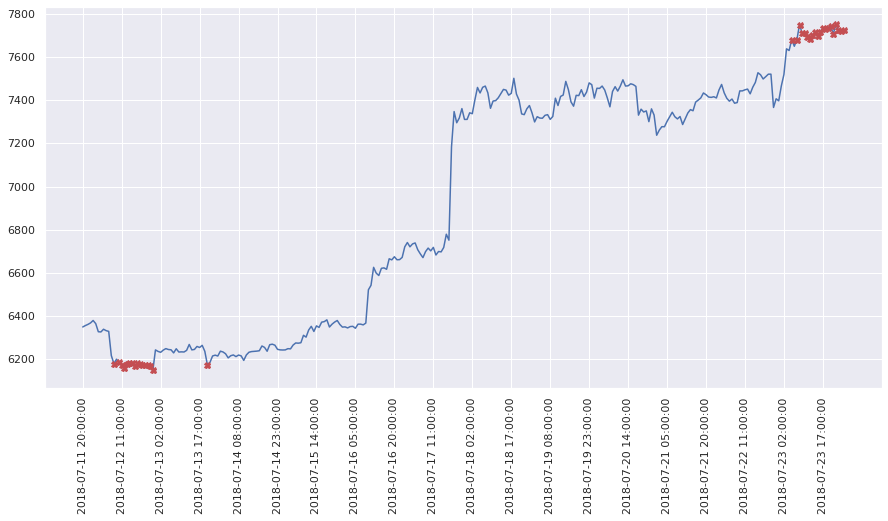

In [ ]:
# Lets how them
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), signal)
plt.plot(
    np.arange(len(signal)),
    signal,
    'X',
    label = 'outliers',
    markevery = outliers,
    c = 'r',
)

# Arrange the plot axis len and scale
plt.xticks(
    np.arange(len(signal))[::15], df['timestamp'][::15], rotation = 'vertical'
)


plt.savefig(PLOTS_PATH + 'multi_peaks' + '.png')
plt.show()


Notes: Some period we see sudden changes i

## 06 -  Correlation analysis

Nromalie all the features

In [ ]:
# Scale thing to a min max scale using tsome  numeric variables
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler().fit(df[['Polarity', 'Sensitivity', 'Close_Price']])
scaled = minmax.transform(df[['Polarity', 'Sensitivity', 'Close_Price']])


Make some correlation over time

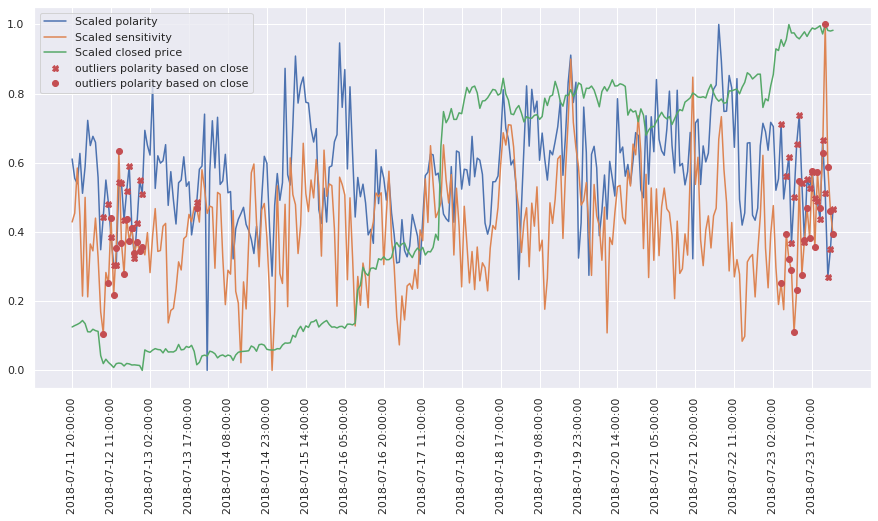

In [ ]:
# Plot the Scaled sensititivy and polarity and some outliers based on close agains the close price
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), scaled[:, 0], label = 'Scaled polarity')
plt.plot(np.arange(len(signal)), scaled[:, 1], label = 'Scaled sensitivity')
plt.plot(np.arange(len(signal)), scaled[:, 2], label = 'Scaled closed price')
plt.plot(
    np.arange(len(signal)),
    scaled[:, 0],
    'X',
    label = 'outliers polarity based on close',
    markevery = outliers,
    c = 'r',
)
plt.plot(
    np.arange(len(signal)),
    scaled[:, 1],
    'o',
    label = 'outliers polarity based on close',
    markevery = outliers,
    c = 'r',
)
plt.xticks(
    np.arange(len(signal))[::15], df['timestamp'][::15], rotation = 'vertical'
)
plt.legend()

plt.savefig(PLOTS_PATH + 'multi_Scaled sensititivy and polarity and some outliers' + '.png')
plt.show()


Note: Nothing imediatle evident and correlated with the response

Do some correlation analyis between the variables

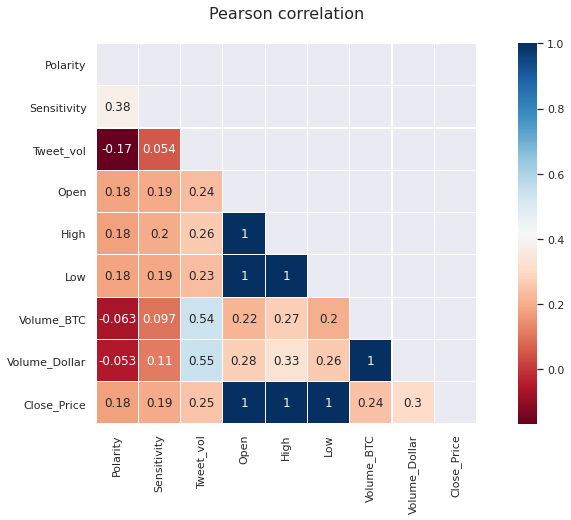

In [ ]:
# Pearson correlation
colormap = plt.cm.RdBu
plt.figure(figsize = (15, 7))
plt.title('Pearson correlation', y = 1.05, size = 16)

mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    df.corr(),
    mask = mask,
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)


plt.savefig(PLOTS_PATH + 'multi_Pearson correlation' + '.png')
plt.show()


#### NOTE: Open, High, Low are atrongly correlated

Correaltion by periods of 42 hours (7 hour daily) 

In [ ]:

# Funciton to contruct an new dataframe with some time lags
def df_shift(df, lag = 0, start = 1, skip = 1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols = {}
    for i in range(start, lag + 1, skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k, v in cols.items():
        columns = v
        dfn = pd.DataFrame(data = None, columns = columns, index = df.index)
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods = i)
            i += 1
        df = pd.concat([df, dfn], axis = 1, join_axes = [df.index])
    return df


In [ ]:
# I gonna set a lag of 42 hours, starting from hour 7, ans skip 7 hours (night)
df_new = df_shift(df, lag = 42, start = 7, skip = 7)
df_new.shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


(294, 70)

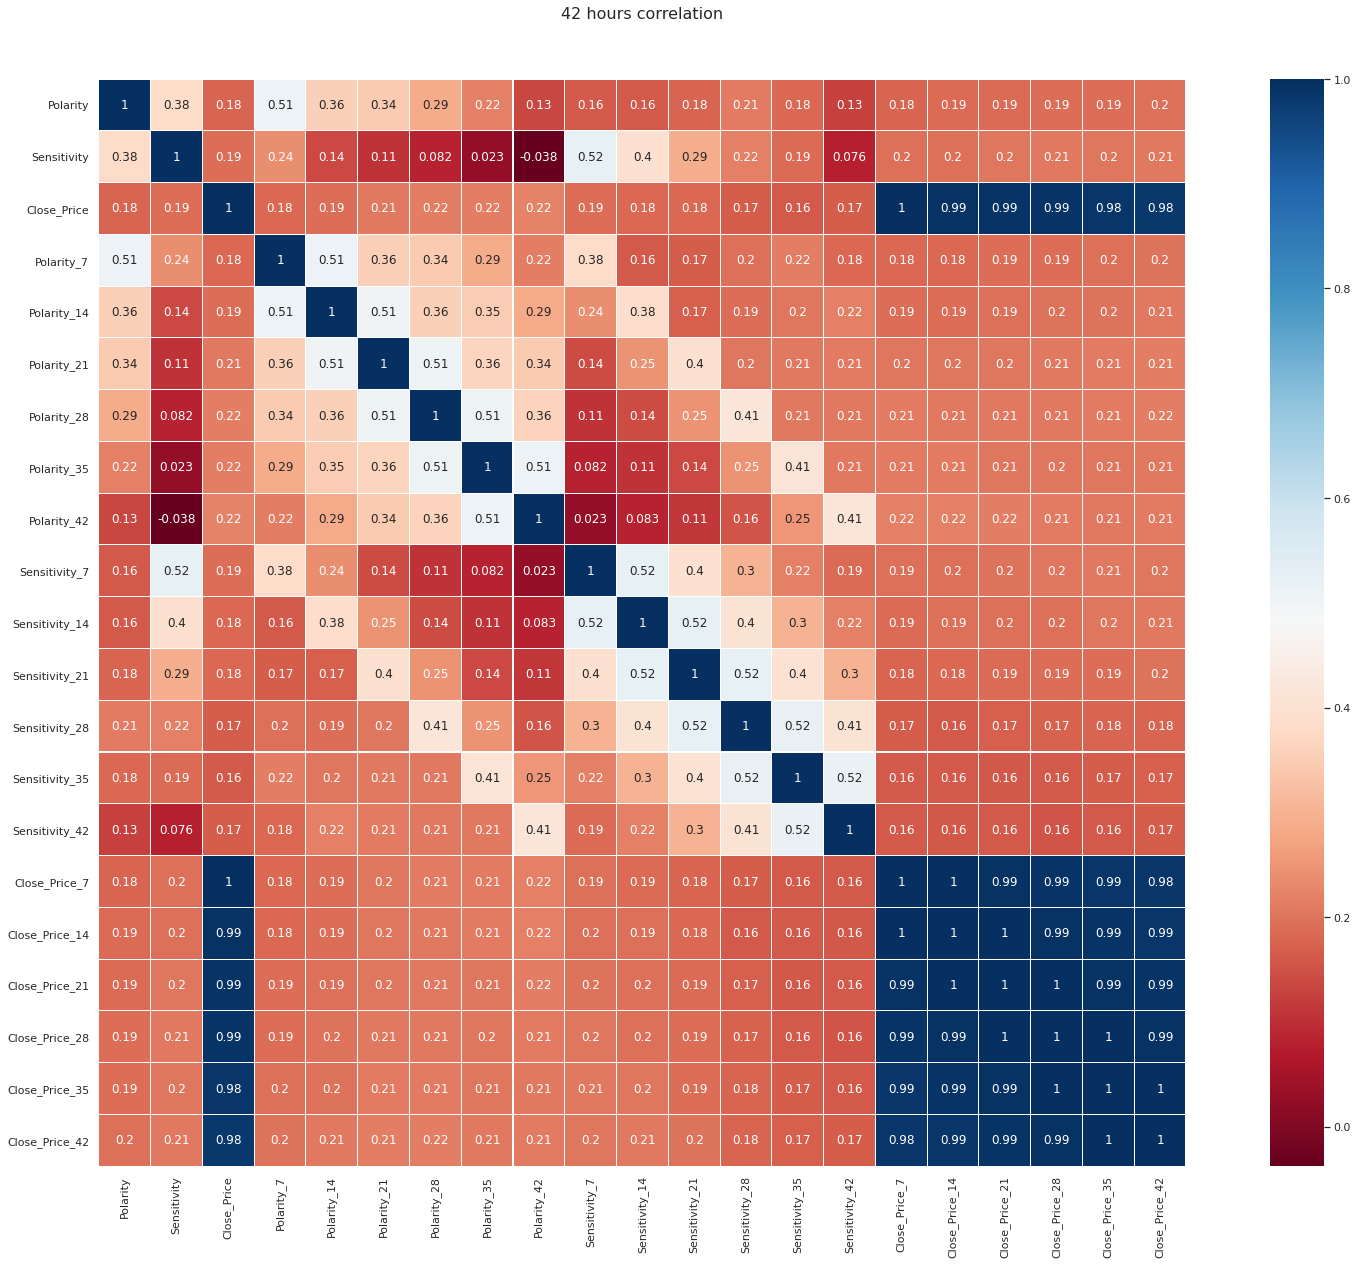

In [ ]:
# Lets plot things
colormap = plt.cm.RdBu
plt.figure(figsize = (30, 20))
ax = plt.subplot(111)
plt.title('42 hours correlation', y = 1.05, size = 16)
selected_column = [
    col
    for col in list(df_new)
    if any([k in col for k in ['Polarity', 'Sensitivity', 'Close']])
]

sns.heatmap(
    df_new[selected_column].corr(),
    ax = ax,
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)

plt.savefig(PLOTS_PATH + 'multi_42 hours correlation' + '.png')
plt.show()


Note: We see come storng correlation with last previous day periods meaning that close days dinamics are well correlated and does not differ too much

##07 - Modeling


Lets make some simple models with several lag memory and compared it agaisn the true target variable

In [ ]:
def moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period, len(signal)):
        buffer.append(signal[i - period : i].mean())
    return buffer
    

In [ ]:
signal = np.copy(df['Close_Price'].values)
ma_7 = moving_average(signal, 7)
ma_14 = moving_average(signal, 14)
ma_30 = moving_average(signal, 30)


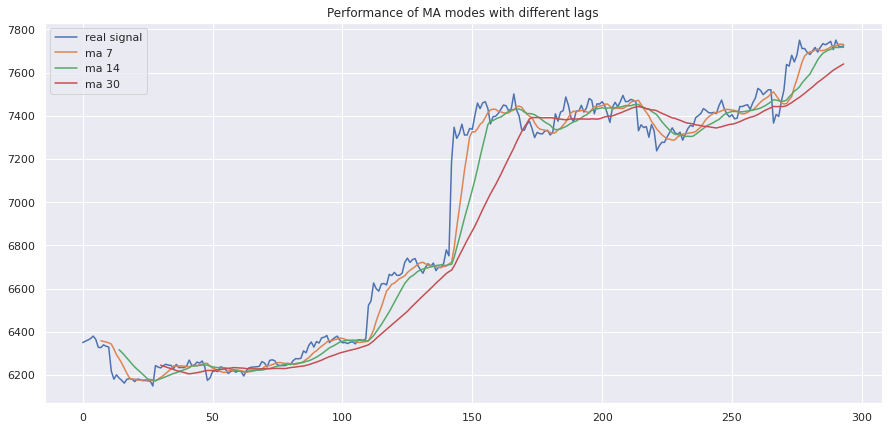

In [ ]:
plt.figure(figsize = (15, 7))
plt.title('Performance of MA modes with different lags')
plt.plot(np.arange(len(signal)), signal, label = 'real signal')
plt.plot(np.arange(len(signal)), ma_7, label = 'ma 7')
plt.plot(np.arange(len(signal)), ma_14, label = 'ma 14')
plt.plot(np.arange(len(signal)), ma_30, label = 'ma 30')
plt.legend()

plt.savefig(PLOTS_PATH + 'multi_Performance of MA modes with different lags' + '.png')
plt.show()



Note: The shortest lag moving average  (order) is more sensitive to the dinamics of the close price. longer memories are not so good.

## 08 - Srt a LSTM multivariate model

In [1]:
# Set lstm hyperparameters 
num_layers = 1
learning_rate = 0.005
size_layer = 128 # number of lstm cells
timestamp = 5
epoch = 500
dropout_rate = 0.6


In [ ]:
# Get the dates to iterate
dates = pd.to_datetime(df.iloc[:, 0]).tolist()


In [ ]:
# Specify the model
class Model:
    def __init__(
        self, learning_rate, num_layers, size, size_layer, forget_bias = 0.8
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        # Specify the number of cells
        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        # Set the variable placeholders
        self.X = tf.placeholder(tf.float32, (None, None, size))

        # Set the target placeholder 
        self.Y = tf.placeholder(tf.float32, (None, size))

        # Define the dropout container
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )

        # Specify number of hidden layers each cell 
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(
            self.outputs[-1],
            size,
            kernel_initializer = tf.glorot_uniform_initializer(), # use glorot to set initial weights xavier weight uniform sampling then scaled 1/sqrt(n) = sqrt(6)/sqrt(ni + ni +1)
        )

        # Agregate the partial batch results
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))

        # Set the optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )


Scale all variables to a min max to ensure convergence


In [ ]:
# optimize the transformer
minmax = MinMaxScaler().fit(
    df[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']].astype(
        'float32'
    )
)

# Scale the variables
df_scaled = minmax.transform(
    df[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']].astype(
        'float32'
    )
)

# Conver to dataframe if not
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()


,0,1,2,3
0,0.611105,0.429055,0.181916,0.125479
1,0.555312,0.454335,0.192380,0.129527
2,0.539534,0.584943,0.131741,0.132931
3,0.627175,0.445375,0.111618,0.137210
4,0.511893,0.214693,0.134156,0.144218


## 09 - Instanciate the computational graph

In [ ]:
tf.reset_default_graph() #Set defaut graph

# Instancia the model with the hyperparameters to the placeholders
modelnn = Model(
    learning_rate, num_layers, df_scaled.shape[1], size_layer, dropout_rate
)
# Start things
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer()) # init all variables 


## 10 - Iterate over the computational graph

In [ ]:

# For each epoch
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer)) # set the init weights
    total_loss = 0 # set the initial loss

    # Specify the batch indices
    for k in range(0, (df_scaled.shape[0] // timestamp) * timestamp, timestamp):
        # extract the corresponding batch variables
        batch_x = np.expand_dims(
            df_scaled.iloc[k : k + timestamp].values, axis = 0
        )
        # extract the correspondig batch target
        batch_y = df_scaled.iloc[k + 1 : k + timestamp + 1].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state # Save last state 
        total_loss += loss # update the loss

    # COmpute the aggregate loss    
    total_loss /= df.shape[0] // timestamp

    # Some debug verbose
    if (i + 1) % 50 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)


epoch: 50 avg loss: 0.010204209448320085
epoch: 100 avg loss: 0.008979850741713468
epoch: 150 avg loss: 0.008667760014790913
epoch: 200 avg loss: 0.0074017616430425955
epoch: 250 avg loss: 0.006587543741575089
epoch: 300 avg loss: 0.006784927641876556
epoch: 350 avg loss: 0.006761252659308757
epoch: 400 avg loss: 0.005222419545793071
epoch: 450 avg loss: 0.004659299859134802
epoch: 500 avg loss: 0.00522640495207803


## 11 - Make some predictions

In [ ]:
# do some predictions
def predict_future(future_count, df, dates, indices = {}):
    date_ori = dates[:]
    cp_df = df.copy() # deep copy to avoid overwritting
    output_predict = np.zeros((cp_df.shape[0] + future_count, cp_df.shape[1]))
    output_predict[0] = cp_df.iloc[0]
    upper_b = (cp_df.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    # For each batch, use the model and make some preds
    for k in range(0, (df.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    cp_df.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(cp_df.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : cp_df.shape[0] + 1] = out_logits
    cp_df.loc[cp_df.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(hours = 1))
    if indices:
        for key, item in indices.items():
            cp_df.iloc[-1, key] = item
    for i in range(future_count - 1):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(cp_df.iloc[-timestamp:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[cp_df.shape[0]] = out_logits[-1]
        cp_df.loc[cp_df.shape[0]] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(hours = 1))
        if indices:
            for key, item in indices.items():
                cp_df.iloc[-1, key] = item
    return {'date_ori': date_ori, 'df': cp_df.values}


In [ ]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer
    

In [ ]:
# Predict the 30 timesteos above
predict_30 = predict_future(30, df_scaled, dates)
predict_30['df'] = minmax.inverse_transform(predict_30['df']) # inver transformation of the variables 


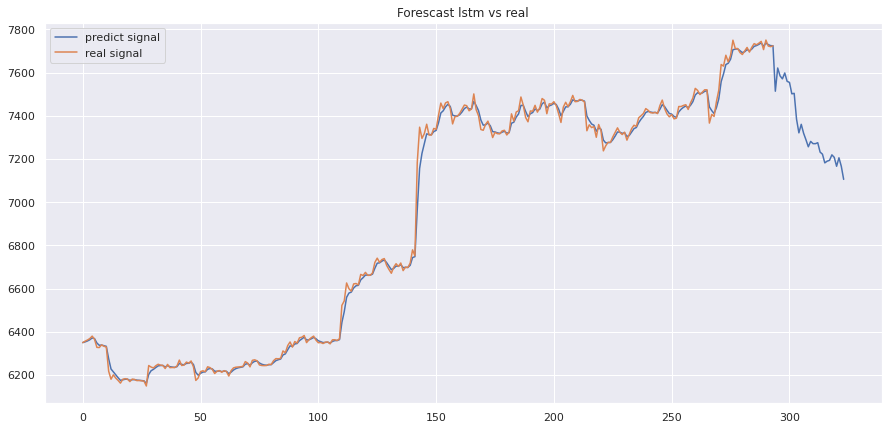

In [ ]:
# Plot the true against the predicted
plt.figure(figsize = (15, 7))
plt.title('Forescast lstm vs real')
plt.plot(
    np.arange(len(predict_30['date_ori'])),
    anchor(predict_30['df'][:, -1], 0.5),
    label = 'predict signal',
)

# Overimpose the real
plt.plot(np.arange(len(signal)), signal, label = 'real signal')
plt.legend()

plt.savefig(PLOTS_PATH + 'multi_Forescast lstm vs real' + '.png')
plt.show()

